In [1]:
import sys
import os
sys.path.append(os.path.abspath('..'))  # Adds parent folder (credit-risk-model) to sys.path
import pandas as pd

In [5]:

from src.proxy_target import calculate_rfm, scale_rfm, perform_kmeans_clustering, label_high_risk_customers

In [2]:
from src.proxy_target import calculate_rfm

# Load raw data
df = pd.read_csv("../data/raw/data.csv")

# Generate RFM table
rfm_df = calculate_rfm(df)

# Preview
rfm_df.head()


,CustomerId,recency,frequency,monetary
0,CustomerId_1,84,1,-10000.0
1,CustomerId_10,84,1,-10000.0
2,CustomerId_1001,90,5,20000.0
3,CustomerId_1002,26,11,4225.0
4,CustomerId_1003,12,6,20000.0


In [3]:
from src.proxy_target import label_high_risk_customers

# Add label to the RFM table
rfm_labeled = label_high_risk_customers(rfm_df)

# Preview
rfm_labeled.head()
rfm_labeled["is_high_risk"].value_counts()


is_high_risk
0    3709
1      33
Name: count, dtype: int64

In [17]:
# Cell 1: Import necessary libraries and functions
import pandas as pd
# Import your functions from the src directory
# Make sure src is in your Python path, or run the notebook from the parent directory
# of src, or add the parent directory of src to sys.path if needed for complex setups.
from src.proxy_target import calculate_rfm, scale_rfm, perform_kmeans_clustering, label_high_risk_customers

# You might need this if your notebook isn't started from the project root
# import sys
# import os
# sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
# from src.proxy_target import calculate_rfm, scale_rfm, perform_kmeans_clustering, label_high_risk_customers

print("Libraries and functions imported successfully!")

Libraries and functions imported successfully!


RFM DataFrame head:
         CustomerId  recency  frequency  monetary
0     CustomerId_1       84          1  -10000.0
1    CustomerId_10       84          1  -10000.0
2  CustomerId_1001       90          5   20000.0
3  CustomerId_1002       26         11    4225.0
4  CustomerId_1003       12          6   20000.0
Cluster summary:
            recency    frequency      monetary
cluster                                      
0        61.859846     7.726699  8.172379e+04
1        29.000000  4091.000000 -1.049000e+08
2        12.716076    34.807692  2.726546e+05
is_high_risk
0    2315
1    1427
Name: count, dtype: int64


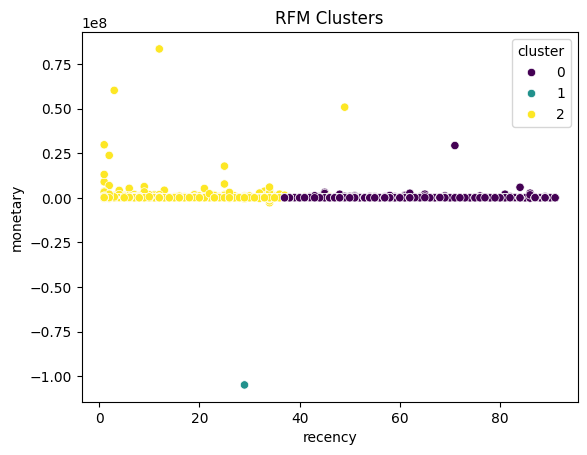

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from src.proxy_target import calculate_rfm, scale_rfm, perform_kmeans_clustering

# Load data
df = pd.read_csv("../data/raw/data.csv")
df["TransactionStartTime"] = pd.to_datetime(df["TransactionStartTime"])

# Define snapshot date for consistent recency calculation
snapshot_date = df["TransactionStartTime"].max() + pd.Timedelta(days=1)

# Step 1: Calculate RFM metrics
rfm = calculate_rfm(df, snapshot_date)
print("RFM DataFrame head:\n", rfm.head())

# Step 2: Scale RFM features
rfm_scaled, scaler = scale_rfm(rfm)

# Step 3: Cluster customers with K-Means
rfm["cluster"], kmeans_model = perform_kmeans_clustering(rfm_scaled)

# Step 4: Analyze cluster centers to determine high-risk cluster
cluster_summary = rfm.groupby("cluster")[["recency", "frequency", "monetary"]].mean()
print("Cluster summary:\n", cluster_summary)

# Assume high-risk cluster is the one with lowest frequency and monetary
high_risk_cluster = cluster_summary.sort_values(["frequency", "monetary"]).index[0]

# Step 5: Create binary is_high_risk label
rfm["is_high_risk"] = (rfm["cluster"] == high_risk_cluster).astype(int)
print(rfm["is_high_risk"].value_counts())

# Step 6: Merge label back into main dataframe
df = df.merge(rfm[["CustomerId", "is_high_risk"]], on="CustomerId", how="left")

# Optional visualization
sns.scatterplot(data=rfm, x="recency", y="monetary", hue="cluster", palette="viridis")
plt.title("RFM Clusters")
plt.show()


In [11]:
cluster_summary = rfm.groupby("cluster")[["recency", "frequency", "monetary"]].mean()
print(cluster_summary)


           recency    frequency      monetary
cluster                                      
0        61.859846     7.726699  8.172379e+04
1        29.000000  4091.000000 -1.049000e+08
2        12.716076    34.807692  2.726546e+05


In [13]:
# Step 1: Summarize clusters
cluster_summary = rfm.groupby("cluster")[["recency", "frequency", "monetary"]].mean()
print(cluster_summary)

# Step 2: Identify high-risk cluster
high_risk_cluster = cluster_summary.sort_values(["frequency", "monetary"]).index[0]
print(f"High-risk cluster identified as: {high_risk_cluster}")

# Step 3: Label customers
rfm["is_high_risk"] = (rfm["cluster"] == high_risk_cluster).astype(int)

# Preview labeled data
print(rfm[["CustomerId", "cluster", "is_high_risk"]].head())


           recency    frequency      monetary
cluster                                      
0        61.859846     7.726699  8.172379e+04
1        29.000000  4091.000000 -1.049000e+08
2        12.716076    34.807692  2.726546e+05
High-risk cluster identified as: 0
        CustomerId  cluster  is_high_risk
0     CustomerId_1        0             1
1    CustomerId_10        0             1
2  CustomerId_1001        0             1
3  CustomerId_1002        2             0
4  CustomerId_1003        2             0


In [15]:
print(risk_labels.columns)


Index(['CustomerId', 'is_high_risk'], dtype='object')


In [16]:
# Confirm this exists
print(rfm.columns)

# If 'is_high_risk' is missing, add it
if "is_high_risk" not in rfm.columns:
    # Re-identify high-risk cluster using existing clustering
    cluster_summary = rfm.groupby("cluster")[["recency", "frequency", "monetary"]].mean()
    high_risk_cluster = cluster_summary.sort_values(["frequency", "monetary"]).index[0]

    rfm["is_high_risk"] = (rfm["cluster"] == high_risk_cluster).astype(int)



Index(['CustomerId', 'recency', 'frequency', 'monetary', 'cluster',
       'is_high_risk'],
      dtype='object')


In [17]:
# Now create the mapping table
risk_labels = rfm[["CustomerId", "is_high_risk"]].drop_duplicates()

# Merge into main df
df = df.merge(risk_labels, on="CustomerId", how="left")

# Fill missing if any
df["is_high_risk"] = df["is_high_risk"].fillna(0).astype(int)

# Verify
print(df["is_high_risk"].value_counts())


is_high_risk
0    84636
1    11026
Name: count, dtype: int64


In [20]:
df["CustomerId"] = df["CustomerId"].astype(str)
risk_labels["CustomerId"] = risk_labels["CustomerId"].astype(str)


In [22]:
# Drop is_high_risk if already exists in df
if "is_high_risk" in df.columns:
    df.drop(columns=["is_high_risk"], inplace=True)

# Now safe to merge
df = df.merge(risk_labels, on="CustomerId", how="left")

# Fill missing values just in case
df["is_high_risk"] = df["is_high_risk"].fillna(0).astype(int)

# ✅ Done
print("✅ Final shape:", df.shape)
print(df[["CustomerId", "is_high_risk"]].head())


✅ Final shape: (95662, 19)
        CustomerId  is_high_risk
0  CustomerId_4406             0
1  CustomerId_4406             0
2  CustomerId_4683             1
3   CustomerId_988             0
4   CustomerId_988             0
